In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
# The actual prior variance
prior_var = 1

use_marcels_colorscheme = True

In [3]:
# This function estimates the expectation by evaluating the estimated variance 
# multiple times and returning the mean

def gauss1d(x, mean, var):
    return 1 / np.sqrt(2 * np.pi * var) * np.exp(-0.5 * ((x - mean) ** 2) / var)

def sim(prop_prior_var, N, alpha=0, nsamples=1000):
    mles = np.empty(nsamples)
    
    for i in range(nsamples):
        npsamples = int(N * alpha)
        nppsamples = N - npsamples
        xlist = np.concatenate((np.random.normal(scale = np.sqrt(prop_prior_var), size=nppsamples), 
                                np.random.normal(scale = np.sqrt(prior_var), size=npsamples)))
        
        prior_evals = gauss1d(xlist, 0, prior_var)
        prop_prior_evals = gauss1d(xlist, 0, prop_prior_var)
        wlist = prior_evals / (alpha * prior_evals + (1 - alpha) * prop_prior_evals)

        var_mle = np.sum((xlist ** 2) * wlist) / np.sum(wlist)
        mles[i] = var_mle
    
    return np.mean(mles)

In [104]:
# This function estimates the expectation using the linear approximation and MC integration
# The linear approximation can give negative values, so this function is UNSTABLE!

def calc(prop_prior_var, N, alpha=0, nsamples=100000):
    xlist = np.random.normal(scale = np.sqrt(prior_var), size=nsamples)
    
    prior_evals = gauss1d(xlist, 0, prior_var)
    prop_prior_evals = gauss1d(xlist, 0, prop_prior_var)
    temp = prop_prior_evals / prior_evals
    wlist = 1 / (alpha + (1 - alpha) * temp)
    
    t0 = xlist ** 2
    t1 = - (xlist ** 2) * (wlist - 1) / N
    t2 = 0 # (xlist ** 2) * (wlist ** 2) / (N ** 2)
    ylist = t0 + t1 + t2
    
    return np.mean(ylist)

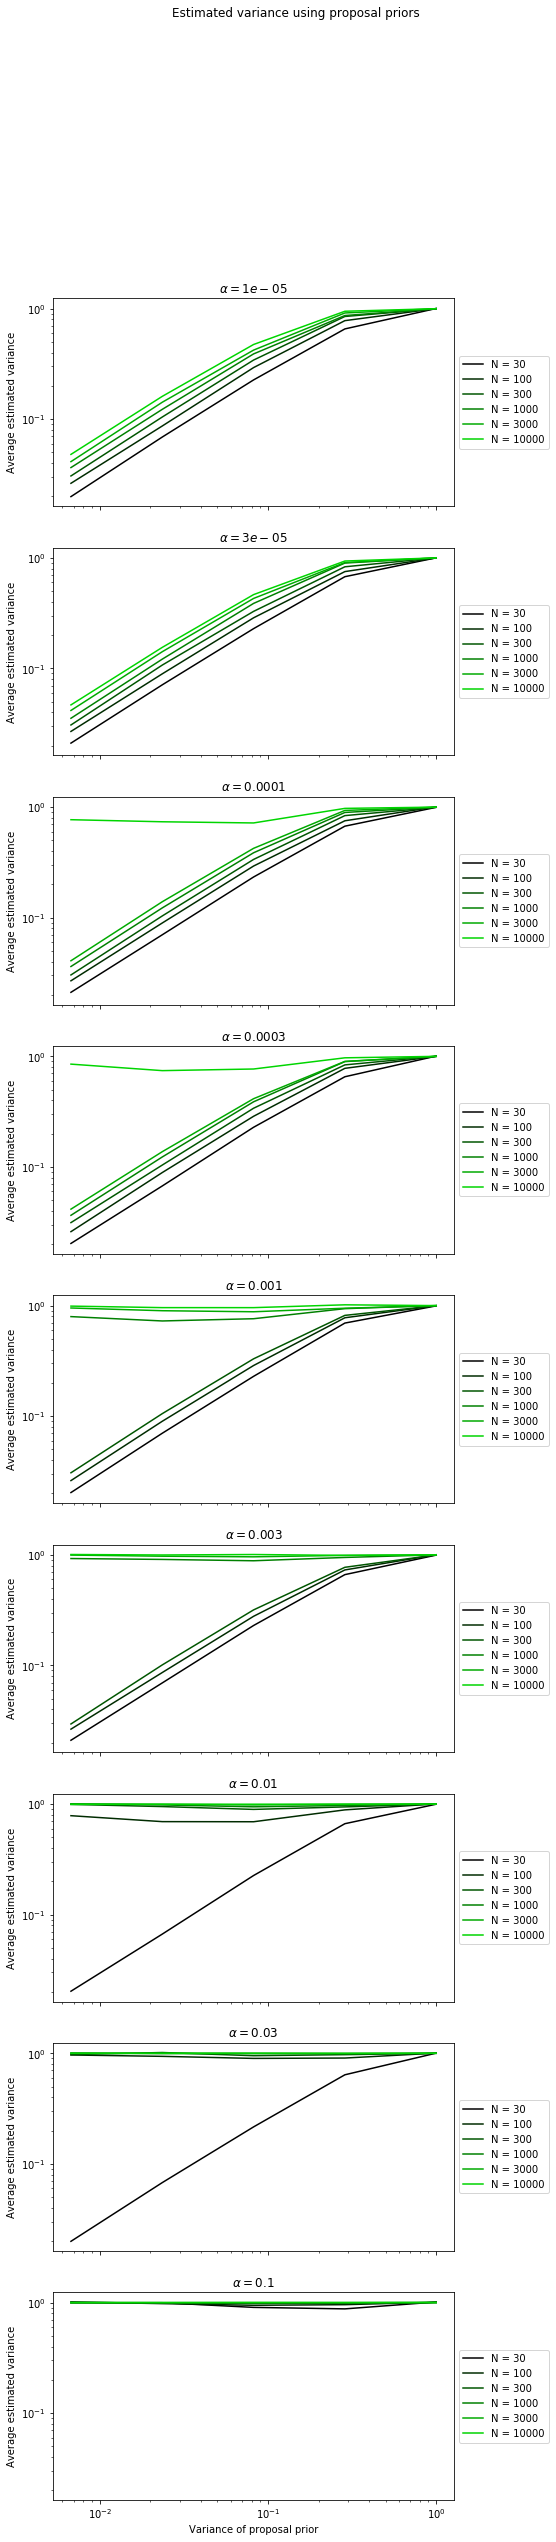

In [112]:
# List of proposal prior variances (x-axis)
vlist = prior_var * np.exp(-np.linspace(0, 5, 5))

Nlist = [ 30, 100, 300, 1000, 3000, 10000 ]

alphas = [ 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1 ]

fig, axes = plt.subplots(len(alphas), sharex=True, sharey=True, figsize = (9, len(alphas) * 4.5))
fig.suptitle("Estimated variance using proposal priors")

for alpha, ax in zip(alphas, axes):

    for j in range(len(Nlist)):
        sim_list = [ sim(i, Nlist[j], alpha=alpha) for i in tqdm(vlist)]

        color = None
        if use_marcels_colorscheme:
            color = [0,j / len(Nlist),0]
        ax.loglog(vlist, sim_list, label="N = {}".format(Nlist[j]), color=color)

    ax.set_title("$\\alpha={}$".format(alpha))

    ax.set_ylabel("Average estimated variance")

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

axes[-1].set_xlabel("Variance of proposal prior")
plt.show()

# Plot sds